# Pset3

## How does the HSR system affect employment growth?

i = cities
k = HSR lines
340 cities = Prefecture-level cities
Yi = 2007-2016 log-change in city employment (has some missing values)
149 new HSR lines planned
84 of them opened by 2016
x = different summary measures of a city's connectedness to the HSR network in 2016 relative to 2007
Lk = Cross-regional links the line has = number of cities the line connects minus 1


## 1-a) Represent change in lines as a shift-share variable

In [1]:
# Define exposure shares and shocks

In [2]:
# Datasets provided
# pset3_cities: List of cities with geographical coordinates and city-level variables.
# pset3_lines: Information on HSR lines, including opening status and number of links.
# pset3_stations: List of cities connected by each HSR line.
# pset3_distances: Distances between pairs of cities.

In [3]:
import pandas as pd
df_cities = pd.read_csv("pset3_cities.csv")
df_lines = pd.read_csv("pset3_lines.csv")
df_stations = pd.read_csv("pset3_stations.csv")
df_distances = pd.read_csv("pset3_distances.csv")

In [4]:
# Step 1: Determine the Opening Status of Each Line (open = dummy)
df_lines['opened'] = df_lines['open'] == 1   

# Step 2: Map cities to lines --> merge df_stations with df_lines to get the opening status for each line-city pair
df_stations_merged = pd.merge(df_stations, df_lines[['lineid', 'opened']], on='lineid')

# Count the number of opened lines for each city
city_line_count = df_stations_merged.groupby('cityid')['opened'].sum().reset_index()
city_line_count.rename(columns={'opened': 'opened_line_count'}, inplace=True)

# Step 3: Calc exposure share for each city
total_opened_lines = df_lines['opened'].sum()
city_line_count['exposure_share'] = city_line_count['opened_line_count'] / total_opened_lines

# Step 4: Calc ΔLines_i for each city
# Merge with df_cities to assign each city its ΔLinesi value
df_cities = pd.merge(df_cities, city_line_count[['cityid', 'exposure_share']], on='cityid')
df_cities['delta_linesi'] = df_cities['exposure_share'] * total_opened_lines

# Step 5: Compute the mean, max, and average of ΔLines_i
mean_delta_linesi = df_cities['delta_linesi'].mean()
max_delta_linesi = df_cities['delta_linesi'].max()
average_delta_linesi = mean_delta_linesi  # Mean and avg are the same in this context

print(f"Mean of ΔLinesi: {mean_delta_linesi}")
print(f"Maximum of ΔLinesi: {max_delta_linesi}")

Mean of ΔLinesi: 1.2792452830188679
Maximum of ΔLinesi: 6.999999999999999


## 1-b) OLS
Estimate (1) by OLS without controls and also adding fixed effects of 30 Chinese provinces. Use heteroskedasticity-robust standard errors. Is the coefficient economically large? Explain why simple OLS with no controls is not likely to produce a causal estimate even if assumptions A1–A3 hold and specification (1) is correct. Is the estimator with province fixed effects more likely to produce a causal estimate?

### Response to 1-b:
##### Estimation Using OLS
Regressing the employment growth (empgrowth) on ΔLinesi (delta_linesi).

##### OLS With Province Fixed Effects
Regressing the employment growth (empgrowth) on ΔLinesi (delta_linesi), including dummy variables for each of the 30 Chinese provinces to control for province-specific effects.

Both regressions should use heteroskedasticity-robust standard errors.

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# OLS without controls
model_no_controls = smf.ols('empgrowth ~ delta_linesi', data=df_cities).fit(cov_type='HC3')
print(model_no_controls.summary())

# OLS with province fixed effects
# Assuming 'province_en' is the column for English names of provinces in df_cities
model_with_fe = smf.ols('empgrowth ~ delta_linesi + C(province_en)', data=df_cities).fit(cov_type='HC3')
print(model_with_fe.summary())

                            OLS Regression Results                            
Dep. Variable:              empgrowth   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     21.50
Date:                Sat, 18 Nov 2023   Prob (F-statistic):           5.89e-06
Time:                        21:33:08   Log-Likelihood:                 16.251
No. Observations:                 236   AIC:                            -28.50
Df Residuals:                     234   BIC:                            -21.58
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2135      0.023      9.367   

### Response to 1-b (continued):
##### Simple OLS without Controls
OLS might not produce a causal estimate due to OVB. Factors, supplementary transportation structures, or differing regional policies could affect both the HSR development and employment growth. Those however are not controlled for in this model.

Adding fixed effects for provinces controls for all time-invariant factors. This makes it more likely to produce a causal estimation, as it accounts for unobserved heterogeneity that may be correlated with both HSR development and employment growth. The consideration of ime-varying confounders is important as well thoguh. 

The size of the coefficient depends on its magnitude and significance. An large effect would suggest that changes in HSR connectivity have a substantial impact on employment growth.

Even with FEs, other unobserved factors at the city level or time-varying province-level factors affecting employment growth could be omitted. While the model with province FEs is better than just an OLS, it might still not fully capture the causal impact of the HSR development on employment growth.

## 1-c) Controls
Which line-level controls does Assumption A1 compel us to include (qk in the notation of the lecture)? Compute the city-level controls Qi corresponding to these qk. How many of them do you have and how do you interpret them? Intuitively, why is including these controls a good idea?

### Response to 1-c:

COMMENT: DIFFERENCE BETWEEN SIMULATED AVERADE TO DMEAN TO TREATMENT OR JUST CONTROL...
KIRILL SAID WE DMEAN THE AVG. 
CHECK LECTURE


*City-Level Controls (Qi):* 
For each city i, aggregate the Lk (# of links) of each line connected to that city - summary stats (sum, average, ...) = relevant measures of line-level characteristic Lk for all lines connected to a city.

*Interpreting the Controls:* 
They represent the city's connectedness to the broader HSR network. A higher value indicates a city's connectedness by lines with more links = a higher level of integration into the network.

*# of Controls:*
The # of controls = # of different summary measures for Lk at the city level. 

*Reasoning for Including These Controls:*
Helps to account for the influence of different HSR lines. Lines with more links might have a more significant impact on employment due to broader reach and stronger/larger integration to the network. 

In [6]:
# Creating dummy variables for each amount of links a city can have (using df_lines)
for j in df_lines['nlinks'].unique():
    df_lines[f'nlinks_{j}'] = (df_lines['nlinks'] == j).astype(int)
    
# Merging df_lines with df_stations
df_stations_with_links = pd.merge(df_stations, df_lines[['lineid'] + [f'nlinks_{j}' for j in df_lines['nlinks'].unique()]], on='lineid')

# Grouping by city and summing the dummies
city_level_controls = df_stations_with_links.groupby('cityid')[[f'nlinks_{j}' for j in df_lines['nlinks'].unique()]].sum()

# Merging the city-level controls with df_cities
df_cities = pd.merge(df_cities, city_level_controls, on='cityid', how='left')

# Printing first few rows (df_cities) to check our work
print(df_cities.head())

   cityid      city_en city_cn province_en province_cn   latitude   longitude  \
0       5        benxi      本溪    liaoning          辽宁  41.290112  123.763660   
1       6    jiayuguan     嘉峪关       gansu          甘肃  39.802452   98.272919   
2       8  shennongjia     神农架       hubei          湖北  31.754316  110.676950   
3       9      tianmen      天门       hubei          湖北  30.656250  113.164120   
4      10        ezhou      鄂州       hubei          湖北  30.322286  114.726000   

   empgrowth  dist_beijing  exposure_share  ...  nlinks_2  nlinks_3  nlinks_9  \
0  -0.034191     642.08984        0.012048  ...         1         0         0   
1   0.316997    1541.75740        0.012048  ...         0         0         1   
2        NaN    1043.39120        0.000000  ...         0         0         0   
3        NaN    1071.33950        0.012048  ...         0         0         0   
4        NaN    1078.81180        0.024096  ...         2         0         0   

   nlinks_4  nlinks_5  nli

## This was the old version:

In [7]:
# Merging df_lines with df_stations to link each city with the lines connected to it and the number of links of each line
# df_cities_with_lines = pd.merge(df_stations, df_lines[['lineid', 'nlinks']], on='lineid')

# Group by city and compute summary statistics (for # of links)
# city_level_controls = df_cities_with_lines.groupby('cityid')['nlinks'].agg(['sum', 'mean', 'max', 'min'])
# city_level_controls['range'] = city_level_controls['max'] - city_level_controls['min']
# city_level_controls.rename(columns={'sum': 'sum_nlinks', 'mean': 'mean_nlinks', 'max': 'max_nlinks', 'min': 'min_nlinks', 'range': 'range_nlinks'}, inplace=True)

# Add these information to df_cities
# df_cities = pd.merge(df_cities, city_level_controls, on='cityid', how='left')

# Check your work by showing the first rows
# print(df_cities.head())

## 1-d) Control for Qi (instead of province FEs)
Estimate (1) by OLS controlling for Qi instead of province fixed effects. Does including Qi change the estimates? Does your estimate rely on Assumptions A2 and A3?

In [8]:
# Print the column names of df_cities
print(df_cities.columns)

Index(['cityid', 'city_en', 'city_cn', 'province_en', 'province_cn',
       'latitude', 'longitude', 'empgrowth', 'dist_beijing', 'exposure_share',
       'delta_linesi', 'nlinks_2', 'nlinks_3', 'nlinks_9', 'nlinks_4',
       'nlinks_5', 'nlinks_1', 'nlinks_18', 'nlinks_6', 'nlinks_7',
       'nlinks_8'],
      dtype='object')


In [9]:
import pandas as pd

# Merge df_lines with df_stations
df_stations_with_links = pd.merge(df_stations, df_lines[['lineid', 'nlinks']], on='lineid')

# Group by city and compute various summary statistics for the number of links
city_level_controls = df_stations_with_links.groupby('cityid')['nlinks'].agg(['sum', 'mean', 'max', 'min'])
city_level_controls['range'] = city_level_controls['max'] - city_level_controls['min']
# No need to rename as we have already correct names from previous renaming
# city_level_controls.rename(columns={'sum': 'sum_nlinks', 'mean': 'mean_nlinks', 'max': 'max_nlinks', 'min': 'min_nlinks', 'range': 'range_nlinks'}, inplace=True)

# Merge city_level_controls with df_cities
df_cities = pd.merge(df_cities, city_level_controls, on='cityid', how='left')


In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define the regression
formula = 'empgrowth ~ delta_linesi + sum + mean + max + min + range'

# OLS 
model = smf.ols(formula, data=df_cities).fit()

# Print regression summary 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              empgrowth   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     7.500
Date:                Sat, 18 Nov 2023   Prob (F-statistic):           1.53e-06
Time:                        21:33:09   Log-Likelihood:                 22.222
No. Observations:                 236   AIC:                            -32.44
Df Residuals:                     230   BIC:                            -11.66
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1912      0.032      5.998   

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# OLS with Qi controls
model_with_qi = smf.ols('empgrowth ~ delta_linesi + sum + mean + max + min + range', data=df_cities).fit(cov_type='HC3')
print(model_with_qi.summary())

                            OLS Regression Results                            
Dep. Variable:              empgrowth   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     6.904
Date:                Sat, 18 Nov 2023   Prob (F-statistic):           5.02e-06
Time:                        21:34:17   Log-Likelihood:                 22.222
No. Observations:                 236   AIC:                            -32.44
Df Residuals:                     230   BIC:                            -11.66
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1912      0.033      5.871   

C:\Users\MSalman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  warnings.warn('covariance of constraints does not have full '


In [14]:
# The warning above indicates that we have a multi-collinearity 

<Axes: >

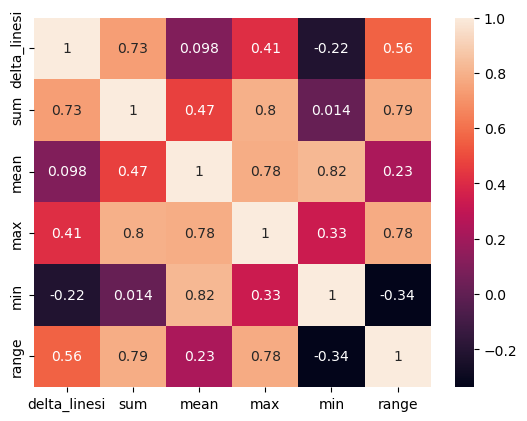

In [16]:
# Check correlations
import seaborn as sns

# Correlation matrix
corr_matrix = df_cities[['delta_linesi', 'sum', 'mean', 'max', 'min', 'range']].corr()
sns.heatmap(corr_matrix, annot=True)

In [18]:
# Calculate the Variance Inflation Factor for each variable. 
# VIF > 5 or 10 --> high multicollinearity.
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF calculation
variables = df_cities[['delta_linesi', 'sum', 'mean', 'max', 'min', 'range']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
print(vif)

   VIF Factor      features
0    5.073898  delta_linesi
1   15.211936           sum
2   97.315432          mean
3         inf           max
4         inf           min
5         inf         range


C:\Users\MSalman\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [19]:
# The warning above indicates that there is perfect multicollinearity among the IVs

from statsmodels.stats.outliers_influence import variance_inflation_factor
# Assuming you've removed some variables from df_cities
variables = df_cities[['delta_linesi', 'sum', 'mean']]  # Adjust this line based on the variables you decide to keep
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
print(vif)

   VIF Factor      features
0    4.818947  delta_linesi
1    7.796525           sum
2    3.059569          mean


In [20]:
# This process is iterative. We have to try different combinations of variables to find a model 
# that does not suffer from multicollinearity.

*Interpretation of the VIF values:*
delta_linesi: VIF = 4.82 < 5 --> no multicollinearity 
sum_nlinks: VIF = 7.80 > 5 < 10 --> Moderate multicollinearity
mean_nlinks: VIF = 3.06. < 5 --> no multicollinearity

*Next Steps:*

sum_nlinks has a VIF above 5. Exploring the impact of removing or adjusting this variable in my model could yield valuable. It is not far above 5. Thus, whether I'll remove it depends on the importance of sum_nlinks in my model.

If sum_nlinks is a crucial variable for your analysis and theoretical framework, you might decide to retain it despite the moderate multicollinearity. Alternatively, you could consider combining sum_nlinks with another variable (like mean_nlinks) or transforming it to reduce multicollinearity.
Model Decision:

The decision to iterate further and modify your model depends on the balance between statistical rigor and the practical importance of each variable in your analysis. If your model's predictive power and interpretability are not significantly hampered by the current level of multicollinearity, you may choose to proceed with the existing model.
In summary, your VIF results suggest a moderate multicollinearity issue with sum_nlinks. The decision to address this by modifying your model depends on the context and purpose of your analysis. If sum_nlinks is important for your theoretical framework or analysis objectives, you might justify keeping it in the model. If not, consider removing it or exploring other ways to reduce its multicollinearity.

## 1-e) Balance Tests
- For each line, pset3_lines reports the operational speed (in km/h). 
- For each city, pset3_cities reports the distance from city i to Beijing (in km). 
- Use these variables to run balance tests. 
- Describe the procedures and which assumption(s) you are testing in each case. 
- Suggest another test that would be helpful to perform if you had the necessary data.

### Balance Test Using Operational Speed

In [21]:
import pandas as pd
from scipy.stats import ttest_ind

# Define a threshold speed to categorize high-speed lines, e.g. 250 km/h
speed_threshold = 250 

# Determine if each line is high-speed or not
df_lines['is_high_speed'] = df_lines['speed'] >= speed_threshold

# Find cities connected to high-speed lines
high_speed_cities = df_stations[df_stations['lineid'].isin(df_lines[df_lines['is_high_speed']]['lineid'])]['cityid'].unique()

# Create a new column in df_cities to indicate if a city is connected to a high-speed line
df_cities['connected_to_high_speed'] = df_cities['cityid'].isin(high_speed_cities)

# Conduct a t-test to compare a characteristic (e.g., empgrowth) between the two groups
high_speed_cities_data = df_cities[df_cities['connected_to_high_speed']]['empgrowth']
low_speed_cities_data = df_cities[~df_cities['connected_to_high_speed']]['empgrowth']

t_stat, p_value = ttest_ind(high_speed_cities_data.dropna(), low_speed_cities_data.dropna())

print(f'T-test results: T-statistic = {t_stat}, P-value = {p_value}')

T-test results: T-statistic = 0.8839113627309639, P-value = 0.37765131692866305


The high p-value (0.4 > 0.05) indicates no or an insignificant difference between the groups, suggesting balance.

### Balance Test Using Distance from Beijing

In [22]:
# Define a distance threshold to categorize cities based on their distance from Beijing, e.g. 500 km
distance_threshold = 500  

# Create a new column in df_cities to indicate if a city is close to Beijing
df_cities['close_to_beijing'] = df_cities['dist_beijing'] <= distance_threshold

# Conduct a t-test to compare a characteristic (e.g., empgrowth) between cities close to and far from Beijing
close_cities_data = df_cities[df_cities['close_to_beijing']]['empgrowth']
far_cities_data = df_cities[~df_cities['close_to_beijing']]['empgrowth']

t_stat, p_value = ttest_ind(close_cities_data.dropna(), far_cities_data.dropna())

print(f'T-test results: T-statistic = {t_stat}, P-value = {p_value}')

T-test results: T-statistic = -3.0030683818101194, P-value = 0.0029629478856092353


The low p-value (0.003 < 0.05) indicates a significant difference between the groups, suggesting potential imbalance.

### Interpretation
The t-test results in the balance tests above help assess whether there are significant differences in employment growth between different groups of cities. 
For cities connected by high-speed versus lower-speed railway lines, the high t-value suggests that these two groups of cities do not systematically in terms of employment growth. This means that they are balanced 
The comparison of cities based on their distance from Beijing aims to identify a potential correlation between proximity to the capital with differences in employment growth. 

These tests help verify the unconfoundedness assumption. Significant differences mean that confounding variables are present. This would require us to adjust our analytical models. Overall, the balance test helps assess whether the groups can be used in my study, and if they are comparable pre-treatment. 

## 1-f) Spacial Data Vis
When working with spatial data, visualizing main variables on a map is invaluable. 
- Display ΔLinesi on the map of China’s regions to visualize your treatment
- Confirm that what you see is consistent with the map of opened lines in Figure 1A of BH
- Then make a map for ΔLinesi after residualizing on Qi to visualize the identifying variation, making it clear which regions are in the “treated group” (in the sense of a positive treatment residual), which are in the “control group,” and which have missing data. (You do not have to make the maps pretty. In Stata, packages shp2dta and spmap are sufficient for this simple tasks. I imagine similar packages exist for R and Python but, if not, doing this part in one language is enough.5)

In [24]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


In [29]:
gdf_merged = gdf.merge(df_cities[['cityid', 'delta_linesi']], left_on='region_key', right_on='cityid', how='left')
import matplotlib.pyplot as plt

# Plotting ΔLinesi
# gdf_merged.plot(column='delta_linesi', legend=True, cmap='viridis')
# plt.title('ΔLinesi Across China’s Regions')
# plt.show()

gdf_merged = gdf.merge(df_cities[['cityid', 'delta_linesi']], left_on='your_shapefile_region_identifier', right_on='cityid', how='left')
gdf_merged.plot(column='delta_linesi', legend=True, cmap='viridis')
plt.title('ΔLinesi Across China’s Regions')
plt.show()

NameError: name 'gdf' is not defined

In [26]:
# gdf = gpd.read_file('chn_admbnda_adm2_ocha.shp')
# print(gdf.columns)

### Vis delta Lines

... tbd

## 3. Include nearby passing lines
You recognize that lines that do not pass through city i but pass nearby may still boost i’s economy. Your friend proposes to model the employment effects of the HSR system as

*Yi = τ2 log NDi + εi,* (2)

where logNDi is the log-distance from i to the nearest city with a HSR. 
(To make sure logNDi is well-defined for cities directly connected to a HSR, we measure the distance between i and itself not as a zero but as a positive number based on city size, capturing the distance between different points within the city. This is the measure you have in the data.)

### 3-a) Reasoning
Provide reasons why specification (2) may still not be great at capturing the effects of railways.

#### Response:
Specification (2) attempts to include the impact of HSR proximity on employment. 

The mere proximity (log-distance=logNDi) to the nearest HSR neglects its actual usage due to e.g. workplaces and educational institutions. Furthermore, there may be confounding variables not considered in this model: HSR is likely only one mode of transportation and the model may neglects last mile mobiliy options that can be crucial for workplace commute. 

The models proposed in this paper may fail to consider threshold effects (e.g. if  there is a minimum level of access or distance to HSR necessary before any significant economic impact can be measured). 

The models do not consider time lagged economic impacts. E.g. improvements in the transportation system may attract private sector investments into local workplaces or schools. 

The models do not account for differences in HSR characteristics, such as quality of service or socioeconomic variables and demographic factors.

### 3-b) Compute without controls & explain
- Still, let’s try it out. Compute logNDi and estimate (2) by OLS without controls.
- Explain why this OLS may not be causal even if the specification is correct.

# IGNORE MY ATTEMPT AT 3-b lol...

In [ ]:
# List column names
df_cities.columns

In [ ]:
df_distances.columns

In [ ]:
df_lines.columns

In [ ]:
df_stations.columns

#### Iterate through each city in df_cities and calculate the distance to every city that has a HSR station (identified by hsr_cities). Then, find the minimum of these distances. 

In [ ]:
# Function to calculate the distance from a city to the nearest HSR city
def calculate_nearest_hsr_distance(city_id, hsr_cities, df_distances):

    # Filter distances where the city is either cityid1 or cityid2
distances = df_distances[((df_distances['cityid1'] == city_id) & (df_distances['cityid2'].isin(hsr_cities))) | 
                             ((df_distances['cityid2'] == city_id) & (df_distances['cityid1'].isin(hsr_cities)))]

# Return the minimum distance
return distances['dist'].min()

# Applying the function to each city in df_cities
df_cities['nearest_hsr_distance'] = df_cities['cityid'].apply(lambda x: calculate_nearest_hsr_distance(x, hsr_cities, df_distances))

# Compute logNDi
df_cities['logNDi'] = np.log(df_cities['nearest_hsr_distance'] + 1)  # Added 1 to avoid log(0)


#### Compute logNDi

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Step 1: Identify cities with a HSR station
hsr_cities = df_stations[df_stations['lineid'].isin(df_lines[df_lines['is_high_speed']]['lineid'])]['cityid'].unique()

# Step 2: Calculate the distance from each city to the nearest HSR city
# This is a placeholder for the actual distance calculation logic
# Replace it with your actual method of computing the nearest HSR city distance
df_cities['nearest_hsr_distance'] = [calculate_nearest_hsr_distance(city, hsr_cities, df_distances) for city in df_cities['cityid']]

# Step 3: Compute logNDi
df_cities['logNDi'] = np.log(df_cities['nearest_hsr_distance'])
print()

#### OLS

In [ ]:
# Defining the dependent and independent variables
X = sm.add_constant(df_cities['logNDi'])  # Independent variable
Y = df_cities['empgrowth']  # Dependent variable

# Performing the OLS regression
model = sm.OLS(Y, X).fit()

# Print out the summary
print(model.summary())

#### Why the OLS May Not Be Causal
Problems with establishing a causal relationship:

OVB
Confounding variables: Another variable actually causes the effect.

Reversed Causality: Cities with higher employment growth may be more likely to be closer to HSR stations. 

Endogeneity: Locations for HSR stations might not chosed randomly, but at economically relevant areas, or areas with certain demographics or socioeconomic structures. 

Time-Lagged Effects (same as above).

### 3-c) Counterfactual Networks
- Briefly describe how Assumptions A1–A3 allow you to construct counterfactual 2016 railway networks (i.e., sets of lines) that were as likely to have happened as the realized network. 
- Simulate 999 such counterfactual networks; make sure to set a seed, such that your results can be exactly reproduced. 
- Compute logNDi for each city in each simulation and average it across your simulations. We denote this average by μi. 
- Report two corrected estimates of τ2: recentering by and controlling for μi. 
- Are they very different from your estimate in 3(b)? 
- What do you learn from this?